JACEK KUJAWSKI

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk 

from datetime import datetime

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
nltk.download('vader_lexicon')

from string import punctuation

from tqdm import tqdm

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [6]:
# 1 Read data - file csv taken from Kaggle

df = pd.read_csv('/content/drive/MyDrive/ds2022-20220717T181853Z-001/ds2022/ds-2022-materialy/p2/data/covid19_tweets.csv')

In [7]:
df.sample(5)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
105286,Valerie Morkevičius,"Hamilton, NY",Assc Prof of Political Science @ColgateUniv. @...,2011-06-22 16:53:57,1259,1507,22705,False,2020-08-11 09:17:09,"But per the CDC's recommendations, the entire ...",['COVID19'],Twitter Web App,False
52061,Lisa H,USA,"Wife of 30yrs to love of my life, Proud Mum of...",2012-06-02 11:55:43,3036,2878,15525,False,2020-08-01 19:16:38,#ResignNowTrump You are completely incompetent...,"['ResignNowTrump', 'COVID19', 'NobodyLikesTrump']",Twitter for iPhone,False
170529,GordonPress #MAGA #KAG #Trump2020 🇺🇸🇺🇸🇺🇸,Tampa,#ArmyForTrump! #Trump #MAGA #LeadRight #KAG,2008-09-21 12:07:38,7329,5247,11834,False,2020-08-30 05:27:35,"Dear Americans - Tomorrow, go to church. Monda...",NaN,Twitter for iPad,False
96786,Firstpost,"Mumbai, India","Incisive opinions, in-depth analysis and views...",2011-02-23 13:09:22,2074573,901,361,True,2020-08-09 03:54:37,"Despite the #Delhi government order, private h...","['Delhi', 'COVID19']",TweetDeck,False
20920,NEWS9,BENGALURU,NEWS9 brings you fastest news and updates on P...,2012-07-12 05:31:57,25611,6,84,True,2020-07-26 06:07:02,A new study published by the @ICMRDELHI has st...,NaN,Twitter Web App,False


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_name         179108 non-null  object
 1   user_location     142337 non-null  object
 2   user_description  168822 non-null  object
 3   user_created      179108 non-null  object
 4   user_followers    179108 non-null  int64 
 5   user_friends      179108 non-null  int64 
 6   user_favourites   179108 non-null  int64 
 7   user_verified     179108 non-null  bool  
 8   date              179108 non-null  object
 9   text              179108 non-null  object
 10  hashtags          127774 non-null  object
 11  source            179031 non-null  object
 12  is_retweet        179108 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 15.4+ MB


In [9]:
df.describe()

,user_followers,user_friends,user_favourites
count,1.791080e+05,179108.000000,1.791080e+05
mean,1.090555e+05,2121.701566,1.444411e+04
std,8.414670e+05,9162.553072,4.452270e+04
min,0.000000e+00,0.000000,0.000000e+00
25%,1.720000e+02,148.000000,2.060000e+02
50%,9.920000e+02,542.000000,1.791000e+03
75%,5.284000e+03,1725.250000,9.388000e+03
max,4.944256e+07,497363.000000,2.047197e+06


In [10]:
df['date'].iloc[0]

'2020-07-25 12:27:21'

In [11]:
# Transform datetime

dates = pd.to_datetime(df['date'])

In [12]:
dates[0]

Timestamp('2020-07-25 12:27:21')

In [13]:
df['date'] = pd.to_datetime(df['date'])

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179108 entries, 0 to 179107
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   user_name         179108 non-null  object        
 1   user_location     142337 non-null  object        
 2   user_description  168822 non-null  object        
 3   user_created      179108 non-null  object        
 4   user_followers    179108 non-null  int64         
 5   user_friends      179108 non-null  int64         
 6   user_favourites   179108 non-null  int64         
 7   user_verified     179108 non-null  bool          
 8   date              179108 non-null  datetime64[ns]
 9   text              179108 non-null  object        
 10  hashtags          127774 non-null  object        
 11  source            179031 non-null  object        
 12  is_retweet        179108 non-null  bool          
dtypes: bool(2), datetime64[ns](1), int64(3), object(7)
memory u

In [15]:
# 2 Clean data

In [16]:
df.isna().any()

user_name           False
user_location        True
user_description     True
user_created        False
user_followers      False
user_friends        False
user_favourites     False
user_verified       False
date                False
text                False
hashtags             True
source               True
is_retweet          False
dtype: bool

In [17]:
sum(df.duplicated())  # Check how many columns could be duplicated

0

In [18]:
sum(df[df['is_retweet'] == False]['text'].duplicated())

425

In [19]:
df[df['text'].duplicated()].head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
2017,GranityPark,New York,Capital Structure Investment Banking,2020-02-02 13:50:53,19,139,2,False,2020-07-25 11:19:30,"73,400 New #Coronavirus Cases in U.S., Nearing...","['Coronavirus', 'Covid19']",TweetCaster for Android,False
2018,Nicholas.Stirpe.Jr,New York 🗽 🇮🇹,Rest at the end not in the middle,2012-03-03 17:18:16,212,261,2,False,2020-07-25 11:19:30,"73,400 New #Coronavirus Cases in U.S., Nearing...","['Coronavirus', 'Covid19']",TweetCaster for Android,False
2748,DD NEWS SRINAGAR,"Srinagar, India","Official Twitter handle of Regional News Unit,...",2013-03-14 09:27:31,9688,318,171,False,2020-07-25 10:49:45,"India conducted over 4.20 lakh tests in a day,...",['COVID19'],Twitter for Android,False
2832,shivendra vatsal,"Noida, India","Nomade',\nJournalist",2013-01-07 13:25:52,94,2213,7716,False,2020-07-25 10:46:56,"India conducted over 4.20 lakh tests in a day,...",['COVID19'],Twitter Web App,False
2950,DailyaddaaNews,New Delhi,Breaking news alerts from India.,2016-10-22 09:18:42,547,29,88,False,2020-07-25 10:42:46,"2,803 new #COVID19 positive cases have been re...",['COVID19'],Twitter Web App,False


In [20]:
# Remove duplicated tweets

df.drop_duplicates(subset=['text'], inplace=True)

In [21]:
sum(df['text'].duplicated())

0

In [22]:
# Show data in image

In [23]:
_stopwords = set(stopwords.words('english'))

In [24]:
wordcloud = WordCloud(stopwords=_stopwords,
                      width=1000,
                      height=800,
                      max_words=500,
                      colormap='Set1',
                      margin=3,
                      max_font_size=150,
                      min_font_size=15).generate(" ".join(df['hashtags'].dropna()))

(-0.5, 999.5, 799.5, -0.5)

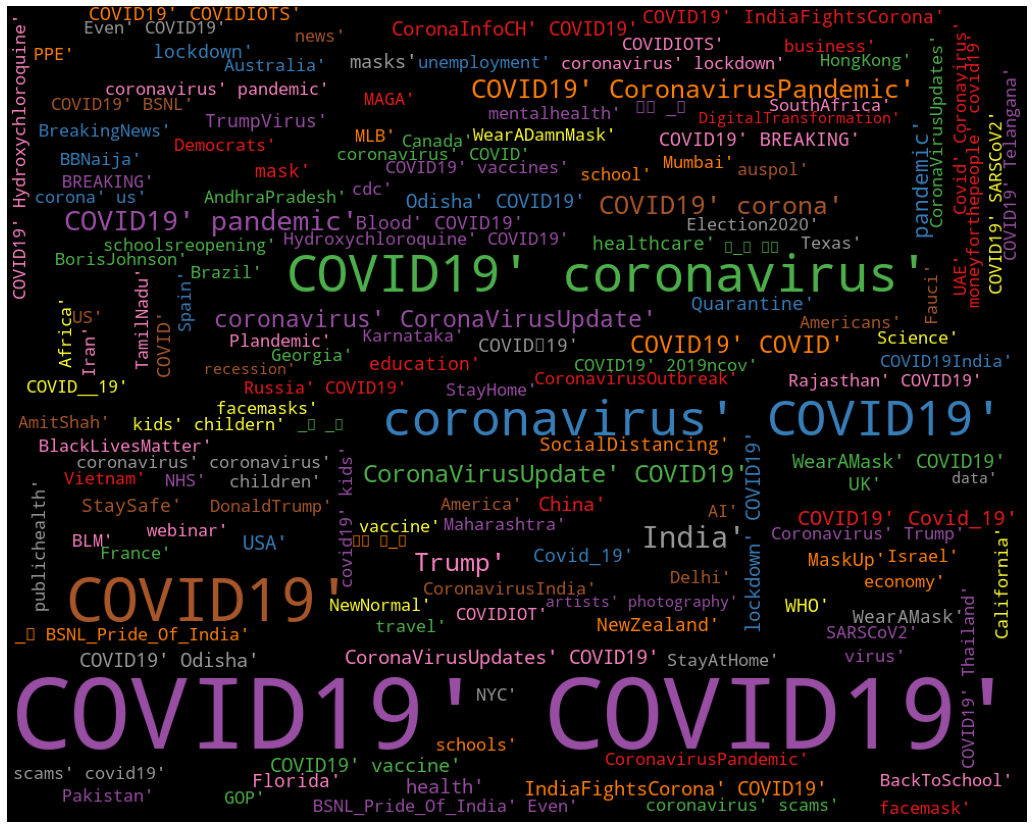

In [25]:
plt.figure(figsize = (20,15))
plt.imshow(wordcloud)
plt.axis('off')

In [26]:
wordcloud = WordCloud(stopwords=_stopwords,
                      width=1000,
                      height=800,
                      max_words=500,
                      colormap='Set1',
                      margin=3,
                      max_font_size=150,
                      min_font_size=15).generate_from_frequencies(
    df['hashtags'].value_counts()
)

(-0.5, 999.5, 799.5, -0.5)

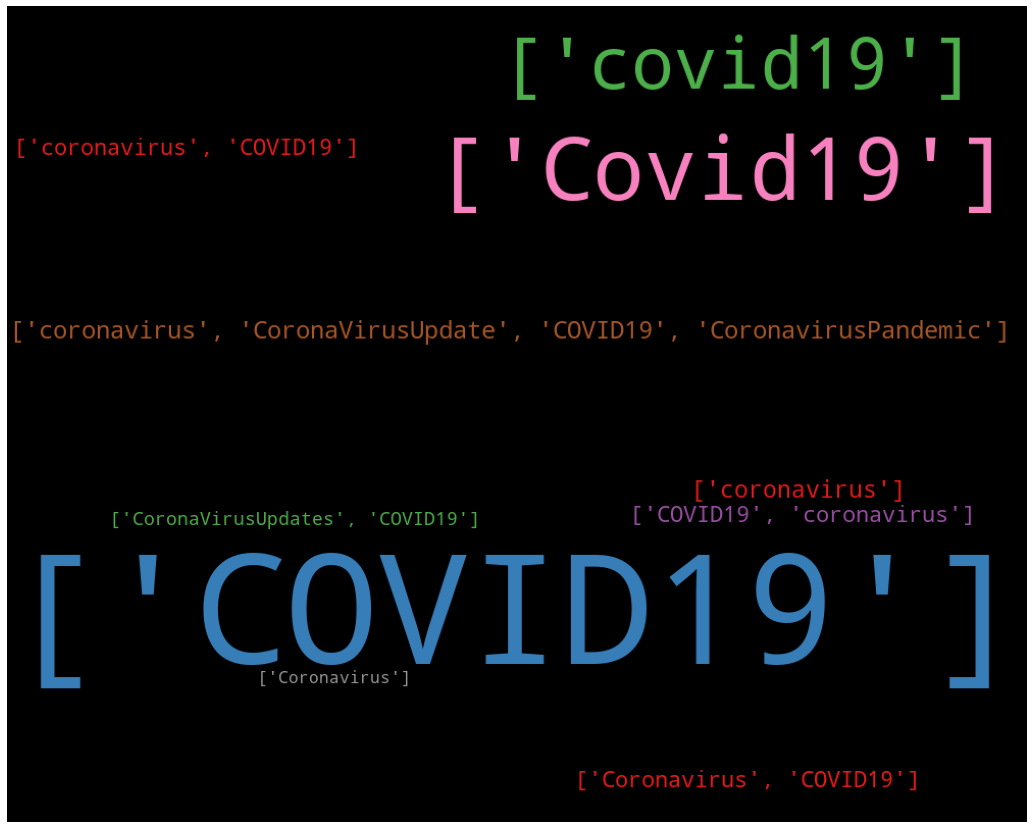

In [27]:
plt.figure(figsize = (20,15))
plt.imshow(wordcloud)
plt.axis('off')

In [28]:
# Clean hashtags

def clean_hashtags(x):
    x = eval(x)
    out = ''
    for y in x:
        y = y.replace("\'", "")
        y = y.lower()
        out = y + ' '
    #print(out)
    return out

In [29]:
cleaned_hashtags = df['hashtags'][~df['hashtags'].isna()].apply(clean_hashtags)

In [30]:
cleaned_hashtags.value_counts()

covid19                 67639
coronavirus              3340
pandemic                  818
coronaviruspandemic       759
covid                     446
                        ...  
complicitgop                1
moneyprinting               1
scared                      1
responsibility              1
heretohelp                  1
Name: hashtags, Length: 18629, dtype: int64

In [31]:
len(cleaned_hashtags)
type(cleaned_hashtags)

pandas.core.series.Series

In [32]:
wordcloud = WordCloud(stopwords=_stopwords,
                      width=1000,
                      height=800,
                      max_words=500,
                      colormap='Set1',
                      margin=3,
                      max_font_size=150,
                      min_font_size=15).generate_from_frequencies(
    cleaned_hashtags.value_counts()
)

(-0.5, 999.5, 799.5, -0.5)

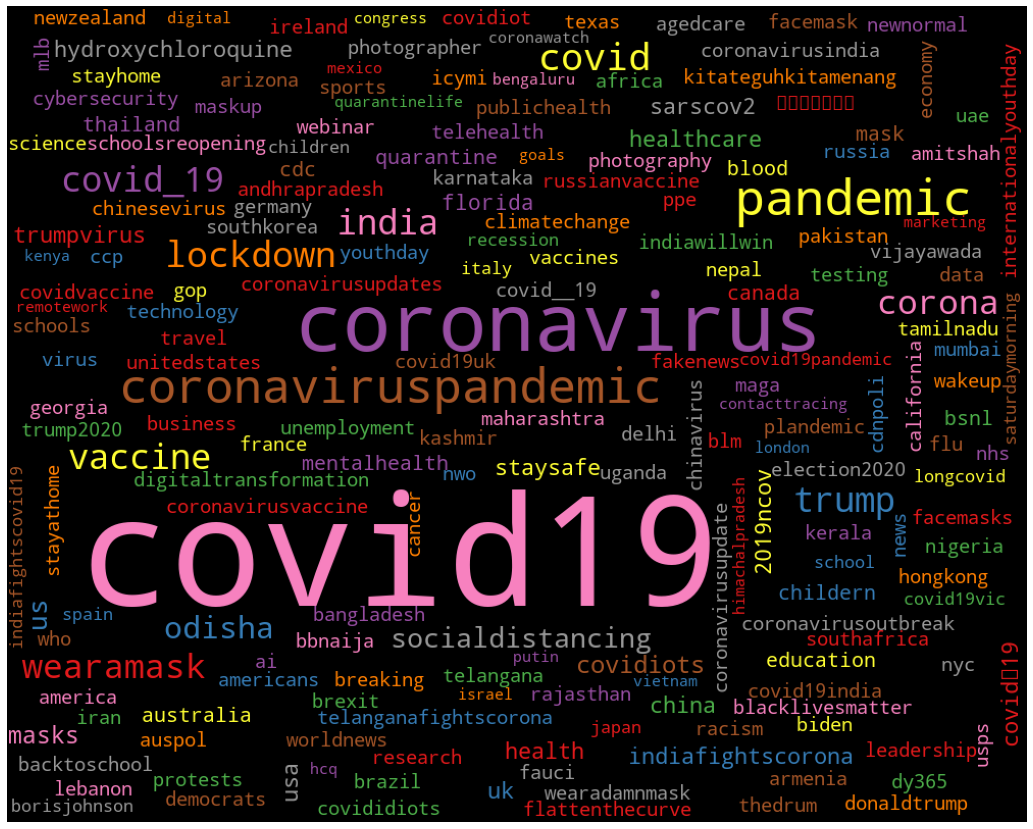

In [33]:
plt.figure(figsize = (20,15))
plt.imshow(wordcloud);
plt.axis('off')

In [34]:
cleaned_hashtags

2            covid19 
3            covid19 
4            covid19 
5            covid19 
6         recruiting 
             ...     
179101       schools 
179102       covid19 
179103     wearamask 
179104       covid19 
179106       covid19 
Name: hashtags, Length: 127349, dtype: object

In [45]:
def clear_covid(x):
#  x = re.sub('covid', '', x)
#  return x
    words = ['covid', 'corona']
    for w in words:
        if x.startswith(w):
            return None
    return x

cleaned_hashtags_without_corona = cleaned_hashtags.apply(clear_covid)

In [46]:
cleaned_hashtags_without_corona.dropna(inplace=True)

In [47]:
cleaned_hashtags_without_corona

6                 recruiting 
11                  abstract 
15        keepsocialdistance 
16                   chennai 
17                  homework 
                 ...         
179097            trumpvirus 
179098                   k12 
179100               schools 
179101               schools 
179103             wearamask 
Name: hashtags, Length: 51964, dtype: object

In [48]:
wordcloud = WordCloud(stopwords=_stopwords,
                      width=1000,
                      height=800,
                      max_words=500,
                      colormap='Set1',
                      margin=3,
                      max_font_size=150,
                      min_font_size=15).generate_from_frequencies(
    cleaned_hashtags_without_corona.value_counts()
)

(-0.5, 999.5, 799.5, -0.5)

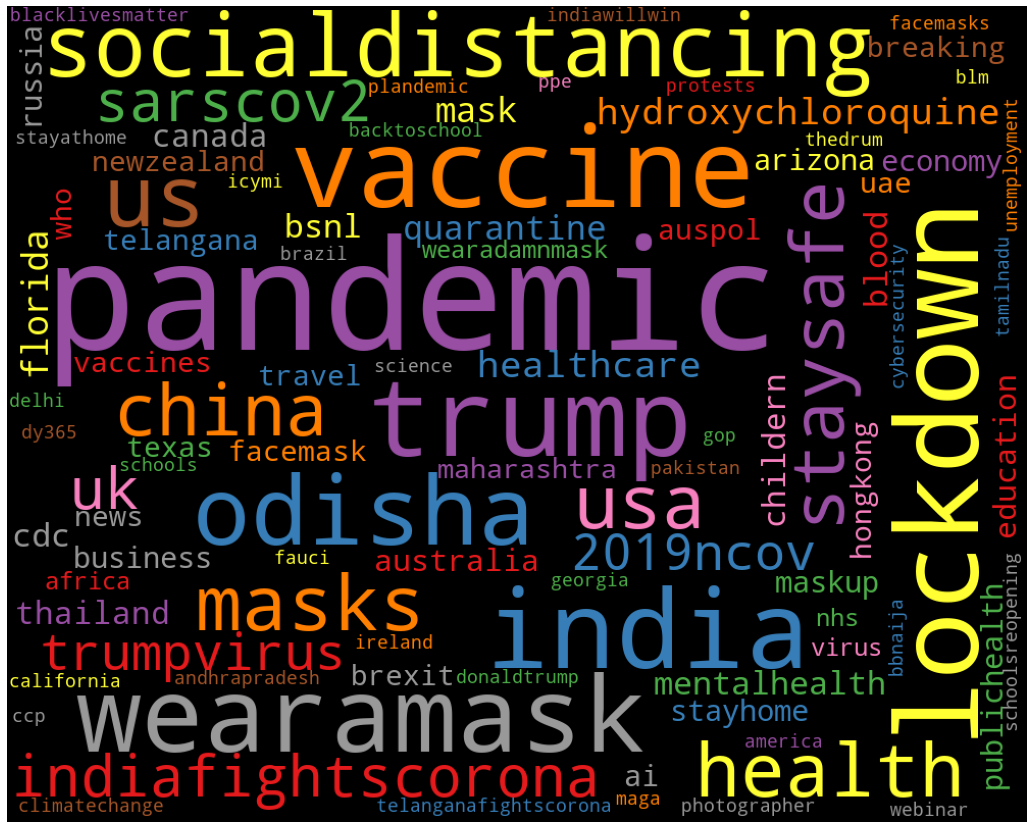

In [49]:
plt.figure(figsize = (20,15))
plt.imshow(wordcloud);
plt.axis('off')

In [50]:
# Analyze frequency of tweets per time

In [51]:
tweets_per_day = df.resample('D', on='date').text.count().sort_index()

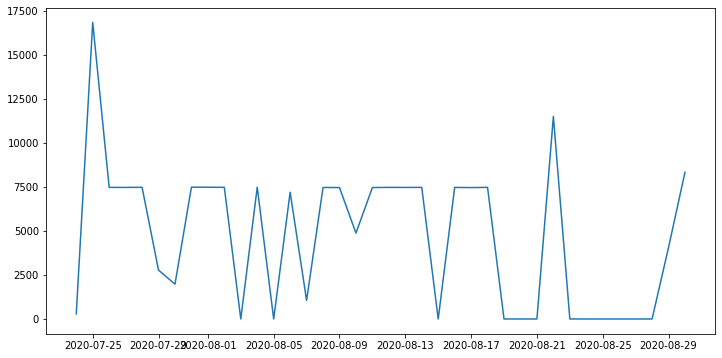

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(tweets_per_day)
plt.show()

In [53]:
# Praca z tekstem

In [54]:
text_data = df['text']

In [55]:
text_data.sample(5)

89791     #EXCLUSIVE video of @juniorbachchan leaving #N...
99266     Our Day 1 Showcase Session will feature #Cloud...
165846    All should accept and should prepare them to l...
137693    @mediparkhosp is now admitting #COVID19 patien...
11251     #CoronaVirus : Single-day spike of 48,916 +Ve ...
Name: text, dtype: object

**Zadanie**: zmień wszystkie ciągi znaków na małe litery.

In [57]:
text_data = text_data.apply(lambda x: x.lower())  # Lambda

In [58]:
text_data.sample(5)

97873     although #covid19 has brought many changes to ...
136512    📍 #rsmlive #covid19 series | challenges of tes...
61388     @realdonaldtrump 155k lives lost from #covid19...
13761     baseball 2020 peanuts cracker jacks and hand s...
72900     #covid19: bihar’s high population density make...
Name: text, dtype: object

**Zadanie**: usuń przecinki i kropki z tekstu.

In [59]:
# przecinki i kropki - da się zrobić inaczej, ale wrócimy do tego później

def remove_dots(x):
    x = x.replace('.', '')
    return x

def remove_commas(x):
    x = x.replace(',', '')
    return x

text_data = text_data.apply(remove_dots)
text_data = text_data.apply(remove_commas)

In [60]:
text_data.sample(5)

166643    congratulations on returning to normal this is...
157961    how can @moderna_tx (given $1bn to develop a v...
80463     heart failure care needs innovative approaches...
135932    @skdxkiller @mshalk @janehayes31527 your post ...
105145    @narendramodi putin announces first #covid19 v...
Name: text, dtype: object

**Zadanie**: usuń linki z tekstu (zaczynające się na `http`).

In [61]:
# usuwamy http: (linki)

def remove_http(x):
    words = x.split()
    out = []
    for word in words:
        if word.startswith('http'):
            pass
        else:
            out.append(word)
    out_str = ' '.join(out)
    return out_str

text_data = text_data.apply(remove_http)

In [62]:
text_data.sample(5)

130137    on native american land contact tracing is sav...
58833     new israeli-made mask claims to offer the "bes...
62836                      #covid19 guidance sorted #raving
93807     what we are learning about covid-19 and kids |...
10065     be a responsible citizen all you have to do is...
Name: text, dtype: object

**Zadanie**: usuń użytkowników i hashtagi (słowa zaczynające się na `@` albo `#`).

In [63]:
# usuwamy użytkowników i hashtagi

def remove_user_mentions(x):
    words = x.split()
    out = []
    for word in words:
        if word.startswith('@'):
            pass
        else:
            out.append(word)
    out_str = ' '.join(out)
    return out_str

text_data = text_data.apply(remove_user_mentions)

In [64]:
text_data.sample(5)

75273     buddy also need one laptop he knows that every...
71259     join us on telegram to earn an income right fr...
148162    hi mr murray is enabling the spread of #covid1...
37556     india: 50000 fresh coronavirus cases in 24 hours-
3528      shocking birth cohort despair mortality of whi...
Name: text, dtype: object

In [65]:
def remove_startstwith(x, characters):
    words = x.split()
    out = []
    for word in words:
        if word.startswith(characters):
            pass
        else:
            out.append(word)
    out_str = ' '.join(out)
    return out_str

In [66]:
text_data = text_data.apply(remove_startstwith, args=['#'])

In [67]:
text_data.sample(5)

65862    if this were jeopardy the question would be: “...
29597    india's covid tally cross 14 lakhs mark with 7...
27362    effect of manual and digital contact tracing o...
57148    “my sperm donor went to and all he brought me ...
69345    the confirmed cases increase rapidly in countr...
Name: text, dtype: object

**Zadanie**: usuń cyfry z tekstu.

In [68]:
def remove_digits(x):
    words = x.split()
    out = []
    for word in words:
        if word.isdigit():
            pass
        else:
            out.append(word)
    out_str = ' '.join(out)
    return out_str

In [69]:
text_data = text_data.apply(remove_digits)

In [70]:
text_data.sample(5)

150958    “all or almost all”? are you kidding me? look ...
12009           stories like this one will never make it to
140806    we are still keeping out page up to date for t...
38633     it's already july has recovered from our life ...
79473     says his recommendation would be to probably m...
Name: text, dtype: object

In [71]:
# Remove special chars - punctuation

def remove_special_chars(x):
    chars = set(punctuation)
    for ch in chars:
        x = x.replace(ch, '')
    return x

In [72]:
text_data = text_data.apply(remove_special_chars)

In [73]:
text_data.sample(5)

11709    this quarantine all of the sudden got me feeli...
9169     if you want your business to survive through k...
1219                            condolences and solidarity
79077    its exactly months since went on amp said to a...
15905                 give 2000month to every american via
Name: text, dtype: object

In [74]:
# Remove stopwords

more_words=['say','going','like','U','u','yankees','diane3443','today','hey','covid', 'amp', 'coronavirus', 'covid19']
stop_words=list(stopwords.words('english'))
stop_words.extend(more_words)
stop_words = set(stop_words)

In [75]:
def remove_words(x, _w):
    splitted = x.split()
    out = []
    for s in splitted:
        if s == _w:
            pass
        else:
            out.append(s)
    out_str = ' '.join(out)
    return out_str


for _word in tqdm(stop_words):
    text_data = text_data.apply(remove_words, args=[_word])

100%|██████████| 192/192 [01:45<00:00,  1.81it/s]


In [76]:
# Remove emoji

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

text_data = text_data.apply(remove_emoji)

In [77]:
# Check data before further processing

In [78]:
text_data.isna().any()

False

In [79]:
len(text_data[text_data == ''])

1156

In [80]:
len(text_data)

178683

In [81]:
text_data = text_data[text_data != '']
len(text_data)

177527

**Zadanie**: stwórz listę wszystkich słów w tweetach

In [82]:
all_words = []

for rec in text_data:
    splitted = rec.split()
    all_words.extend(splitted)

In [83]:
len(all_words)

1502063

In [84]:
# Check frequency of words

In [85]:
pd.value_counts(all_words)

cases       18427
new         14648
people       9034
deaths       7378
us           6878
            ...  
meeka           1
easing…         1
101st           1
tortures        1
grandc…         1
Length: 100845, dtype: int64

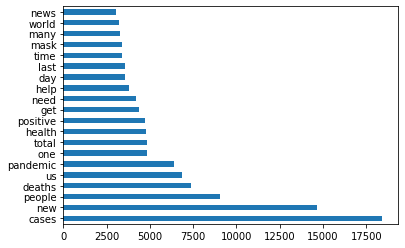

In [86]:
plt.figure()
pd.value_counts(all_words)[:20].plot(kind='barh')
plt.show()

**Zadanie**: Dołącz (`join`) kolumnę z przetworzonym tekstem do bazowej ramki danych. Usuń wiersze, gdzie brakuje wartości (dla przetworzonego tekstu).

In [87]:
text_data.name = 'processed'
ndf = df.join(text_data)

In [88]:
ndf.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,processed
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,smelled scent hand sanitizers someone past wou...
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,wouldnt made sense players pay respects a…
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,trump never claimed hoax claim effort to…
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,one gift give appreciation simple things alway...
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,july media bulletin novel


In [89]:
ndf = ndf[~ndf['processed'].isna()]

In [90]:
ndf.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,processed
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False,smelled scent hand sanitizers someone past wou...
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False,wouldnt made sense players pay respects a…
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False,trump never claimed hoax claim effort to…
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False,one gift give appreciation simple things alway...
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False,july media bulletin novel
